In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import wiener, estimate_sigma
import pywt
import os

In [ ]:
import zipfile
import os

zip_path = '/content/DIP Dataset Cityscape.zip'
extract_path = '/content/cityscapes_gt'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted to:", extract_path)

✅ Extracted to: /content/cityscapes_gt


**Load and Display a Segmentation Mask**

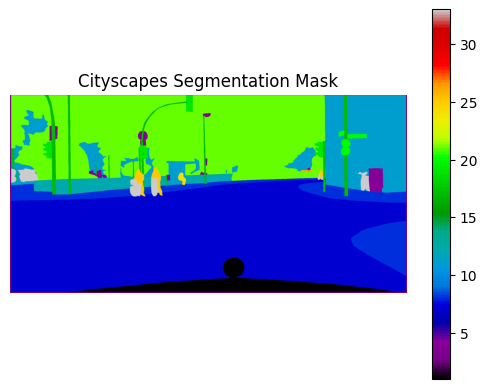

In [ ]:
import glob

label_paths = glob.glob(f"{extract_path}/gtFine/val/**/*.png", recursive=True)
label_paths = [p for p in label_paths if "labelIds" in p]
mask_path = label_paths[0]

mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

plt.imshow(mask, cmap='nipy_spectral')
plt.title("Cityscapes Segmentation Mask")
plt.axis('off')
plt.colorbar()
plt.show()

**Spatial Filtering**

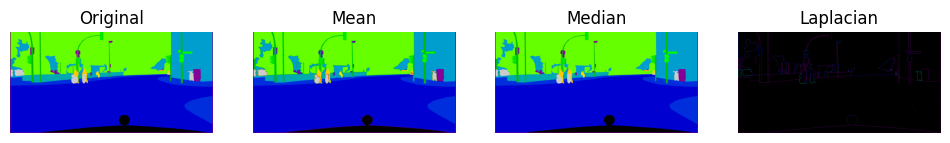

In [ ]:
def apply_spatial_filters(image):
    mean = cv2.blur(image, (5,5))
    median = cv2.medianBlur(image, 5)
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    return mean, median, np.uint8(np.absolute(laplacian))

mean, median, lap = apply_spatial_filters(mask)

plt.figure(figsize=(12, 4))
titles = ['Original', 'Mean', 'Median', 'Laplacian']
for i, img in enumerate([mask, mean, median, lap]):
    plt.subplot(1, 4, i+1)
    plt.imshow(img, cmap='nipy_spectral')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

**Frequency Domain Filtering**

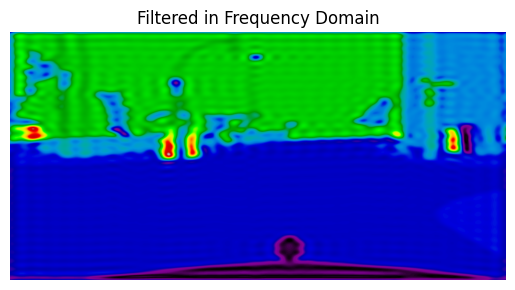

In [ ]:
def frequency_filter(image):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = image.shape
    crow, ccol = rows//2, cols//2
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1

    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])

    return np.uint8(cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX))

f_img = frequency_filter(mask)

plt.imshow(f_img, cmap='nipy_spectral')
plt.title("Filtered in Frequency Domain")
plt.axis('off')
plt.show()

**Image Restoration**

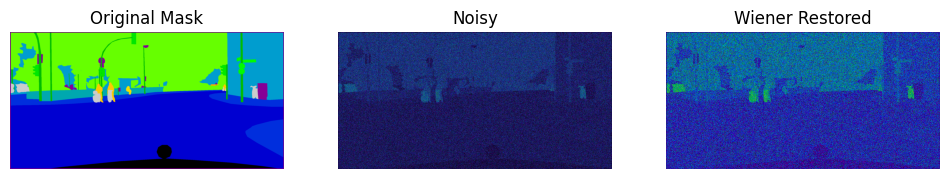

In [ ]:
from skimage.restoration import wiener
from skimage.util import random_noise

noisy = random_noise(mask, mode='gaussian', var=0.01)
restored = wiener(noisy, psf=np.ones((5, 5)) / 25, balance=0.1)

noisy_uint8 = np.uint8(noisy * 255)
restored_uint8 = np.uint8(np.clip(restored, 0, 1) * 255)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(mask, cmap='nipy_spectral')
plt.title("Original Mask")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_uint8, cmap='nipy_spectral')
plt.title("Noisy")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(restored_uint8, cmap='nipy_spectral')
plt.title("Wiener Restored")
plt.axis('off')
plt.show()

**Segmentation via Mask Thresholding**

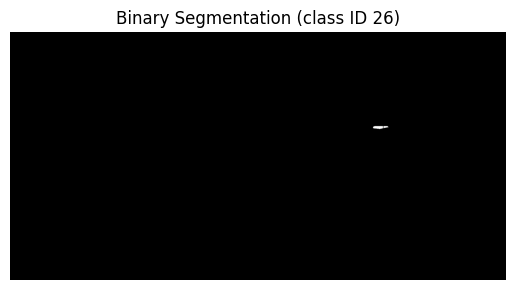

In [ ]:
target_class = 26
binary_mask = np.uint8(mask == target_class) * 255

plt.imshow(binary_mask, cmap='gray')
plt.title(f"Binary Segmentation (class ID {target_class})")
plt.axis('off')
plt.show()

**Morphological Processing**

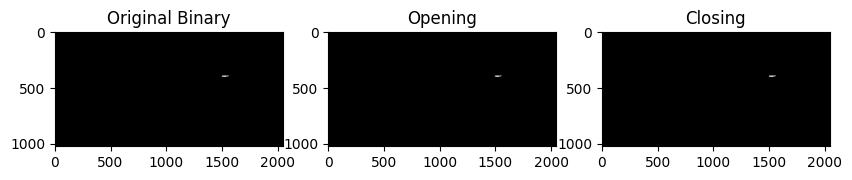

In [ ]:
kernel = np.ones((5,5), np.uint8)
opened = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1); plt.imshow(binary_mask, cmap='gray'); plt.title("Original Binary")
plt.subplot(1, 3, 2); plt.imshow(opened, cmap='gray'); plt.title("Opening")
plt.subplot(1, 3, 3); plt.imshow(closed, cmap='gray'); plt.title("Closing")
plt.show()

**Object Counting via Contours**

✅ Detected 1 objects for class ID 26


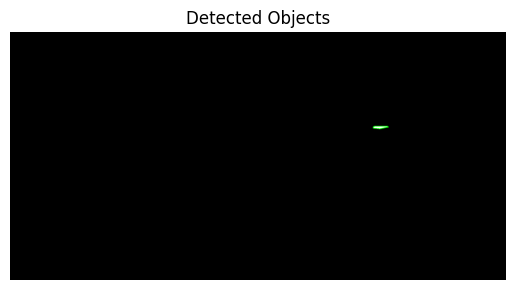

In [ ]:
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0,255,0), 2)

print(f"✅ Detected {len(contours)} objects for class ID {target_class}")

plt.imshow(contour_img)
plt.title("Detected Objects")
plt.axis('off')
plt.show()

**Image Compression & Quality Metrics**

PSNR: 48.13
SSIM: 0.99


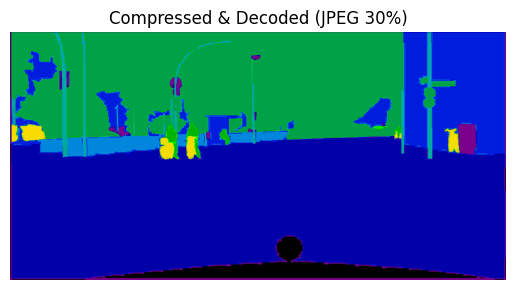

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

_, enc = cv2.imencode('.jpg', mask, [cv2.IMWRITE_JPEG_QUALITY, 30])
decoded = cv2.imdecode(enc, cv2.IMREAD_UNCHANGED)

print(f"PSNR: {psnr(mask, decoded):.2f}")
print(f"SSIM: {ssim(mask, decoded):.2f}")

plt.imshow(decoded, cmap='nipy_spectral')
plt.title("Compressed & Decoded (JPEG 30%)")
plt.axis('off')
plt.show()

In [ ]:
import zipfile

zip_path = "/content/DIP Dataset Cityscape.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.printdir()


File Name                                             Modified             Size
README                                         2016-02-20 14:30:44          298
license.txt                                    2016-02-17 23:01:14         1646
gtFine/train/                                  2016-02-16 11:44:06            0
gtFine/train/jena/                             2016-02-16 11:43:26            0
gtFine/train/jena/jena_000020_000019_gtFine_labelIds.png 2016-02-16 11:43:24        15156
gtFine/train/jena/jena_000092_000019_gtFine_polygons.json 2016-02-16 11:43:24       167197
gtFine/train/jena/jena_000061_000019_gtFine_polygons.json 2016-02-16 11:43:24       154133
gtFine/train/jena/jena_000104_000019_gtFine_polygons.json 2016-02-16 11:43:26        87002
gtFine/train/jena/jena_000064_000019_gtFine_labelIds.png 2016-02-16 11:43:24        14404
gtFine/train/jena/jena_000015_000019_gtFine_instanceIds.png 2016-02-16 11:43:22        21345
gtFine/train/jena/jena_000041_000019_gtFine_labelIds.p